In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -q timm

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt

# Paths
TRAIN_DIR = "/content/gdrive/MyDrive/Workshops/data/train"
VAL_DIR = "/content/gdrive/MyDrive/Workshops/data/val"
TEST_DIR = "/content/gdrive/MyDrive/Workshops/data/test"

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 6
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sanity check
for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    if not os.path.exists(d):
        print(f"❌ Not found: {d}")
    elif not os.listdir(d):
        print(f"⚠️ Empty: {d}")
    else:
        print(f"✅ Directory OK: {d}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.0 MB/s eta 0:00:00
✅ Directory OK: /content/gdrive/MyDrive/Workshops/data/train
✅ Directory OK: /content/gdrive/MyDrive/Workshops/data/val
✅ Directory OK: /content/gdrive/MyDrive/Workshops/data/test


In [ ]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load datasets
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=transform)
val_ds = datasets.ImageFolder(VAL_DIR, transform=transform)
test_ds = datasets.ImageFolder(TEST_DIR, transform=transform)

# Data loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [ ]:
model = timm.create_model('efficientnet_b0', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)
model = model.to(DEVICE)

# Freeze base
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
def train(model, loader):
    model.train()
    total, correct, loss_total = 0, 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return correct / total, loss_total / len(loader)

def evaluate(model, loader):
    model.eval()
    total, correct, loss_total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            loss_total += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
    return correct / total, loss_total / len(loader)

train_accs, val_accs = [], []
train_losses, val_losses = [], []
for epoch in range(10):
    train_acc, train_loss = train(model, train_loader)
    val_acc, val_loss = evaluate(model, val_loader)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"[Epoch {epoch+1}] ✅ Train: {train_acc:.4f}, Val: {val_acc:.4f}")

[Epoch 1] ✅ Train: 0.7905, Val: 0.9200
[Epoch 2] ✅ Train: 0.9371, Val: 0.9417
[Epoch 3] ✅ Train: 0.9414, Val: 0.9383
[Epoch 4] ✅ Train: 0.9557, Val: 0.9350
[Epoch 5] ✅ Train: 0.9605, Val: 0.9433
[Epoch 6] ✅ Train: 0.9629, Val: 0.9550
[Epoch 7] ✅ Train: 0.9633, Val: 0.9433
[Epoch 8] ✅ Train: 0.9719, Val: 0.9517
[Epoch 9] ✅ Train: 0.9719, Val: 0.9483
[Epoch 10] ✅ Train: 0.9719, Val: 0.9517


In [ ]:
# Unfreeze top 20% of layers
for param in model.parameters():
    param.requires_grad = True

n_total = len(list(model.parameters()))
n_unfreeze = int(n_total * 0.2)
for param in list(model.parameters())[:-n_unfreeze]:
    param.requires_grad = False

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

for epoch in range(3):
    train_acc, train_loss = train(model, train_loader)
    val_acc, val_loss = evaluate(model, val_loader)
    print(f"[Fine-tune {epoch+1}] ✅ Train: {train_acc:.4f}, Val: {val_acc:.4f}")


[Fine-tune 1] ✅ Train: 0.9795, Val: 0.9550
[Fine-tune 2] ✅ Train: 0.9781, Val: 0.9617
[Fine-tune 3] ✅ Train: 0.9857, Val: 0.9617


In [ ]:
test_acc, test_loss = evaluate(model, test_loader)
print(f"🎯 Test Accuracy: {test_acc:.4f}")

# Save model
torch.save(model.state_dict(), "broad_category_classifier.pt")
print("✅ Model saved as 'broad_category_classifier.pt'")

# Save the entire model (architecture + weights)
torch.save(model, "broad_category_classifier_full.pt")
print("✅ Model saved as 'broad_category_classifier_full.pt'")

🎯 Test Accuracy: 0.9800
✅ Model saved as 'broad_category_classifier.pt'
✅ Model saved as 'broad_category_classifier_full.pt'


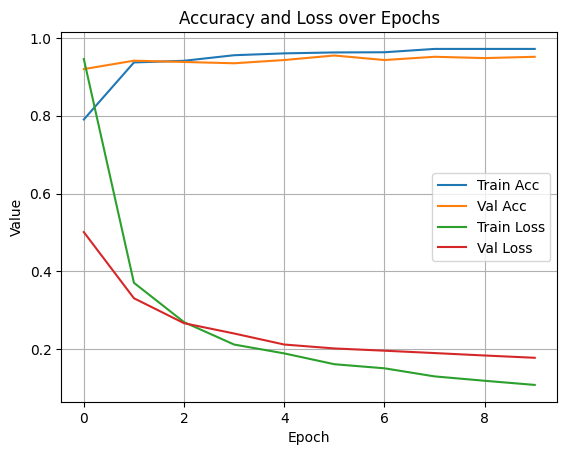

In [ ]:
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Accuracy and Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()